c:\Users\vinh-nt\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-12 16:01:29.613 | INFO     | src.config:<module>:15 - PROJ_ROOT path is: D:\DataLocal\vinh-nt\My Documents\GitHub\Retail-Layout-Optimization-with-ML-Metaheuristics
[I 2025-08-12 16:01:29,763] A new study created in memory with name: no-name-3decc200-3f0e-44a1-98e6-6bddcee76157
c:\Users\vinh-nt\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
[I 2025-08-12 16:01:32,698] Trial 0 finished with value: 26.585941873906158 and parameters: {'lift_threshol

Best params: {'lift_threshold': 1.8939237527802988, 'w_lift': 0.10610829917726133, 'w_conf': 0.3236200316297364, 'w_margin': 0.017186150268958828, 'gamma': 0.5823017145915953, 'w_aff': 1.99339127092514, 'w_entr': 1.9846961790578288, 'gamma_support': 0.9985401253469507}
Best layout (from Optuna): ['Long nao, HP diet ctrung', 'Khu mui khong khi', 'SPham cham soc rang mieng', 'SP ve sinh, tay rua, nrc', 'Dung cu phuc vu SK&SD', 'San pham ve sinh', 'Tau hu cac loai', 'Hai san dong lanh', 'Cha gio', 'Rau,cu,trai cay dong lanh', 'Com, xoi dong lanh', 'San pham che bien d.lanh', 'Tru mat khac (FLAN)', 'Kem cac loai', 'Thit dong lanh', 'Com, gao, nep cac loai', 'San pham ch.bien dong goi', 'Hat, dau rang', 'Mat ong', 'San pham thong cau, cong', 'Banh(tuoi,mi)TS Cap103-10', 'Khu mui co the', 'San pham cham soc toc', 'Hang say kho', 'San pham cham soc co the', 'Giay ve sinh', 'Ta giay, ta lot, tam lot', 'Do dung mot lan', 'Do dung nau an, uong', 'Do dung s.hoat gia dinh', 'Do dung nha bep', 'VSi

c:\Users\vinh-nt\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Best layout: ['Long nao, HP diet ctrung', 'Khu mui khong khi', 'SPham cham soc rang mieng', 'SP ve sinh, tay rua, nrc', 'Dung cu phuc vu SK&SD', 'San pham ve sinh', 'Tau hu cac loai', 'Cha gio', 'Hai san dong lanh', 'Rau,cu,trai cay dong lanh', 'Com, xoi dong lanh', 'San pham che bien d.lanh', 'Tru mat khac (FLAN)', 'Kem cac loai', 'Thit dong lanh', 'Com, gao, nep cac loai', 'San pham ch.bien dong goi', 'Do dung mot lan', 'Mat ong', 'San pham  tu ngu coc', 'Hat, dau rang', 'Khu mui co the', 'San pham cham soc toc', 'San pham cham soc co the', 'Giay ve sinh', 'Ta giay, ta lot, tam lot', 'Sua cac loai', 'Banh(tuoi,mi)TS Cap103-10', 'Do dung nau an, uong', 'Do dung s.hoat gia dinh', 'Do dung nha bep', 'VSinh nha, thiet bi(choi)', 'Hang say kho', 'Mut, bo hat', 'Thuc an cho vat nuoi', 'San pham cham soc SK baby', 'Caphe', 'Bot cac loai', 'VS nha bep(co san,cxoong)', 'Dien nha', 'SPham cham soc suc khoe', 'San pham cham soc mat', 'Ruou co nong do', 'Bia', 'San pham thong cau, cong', 'Nuoc 

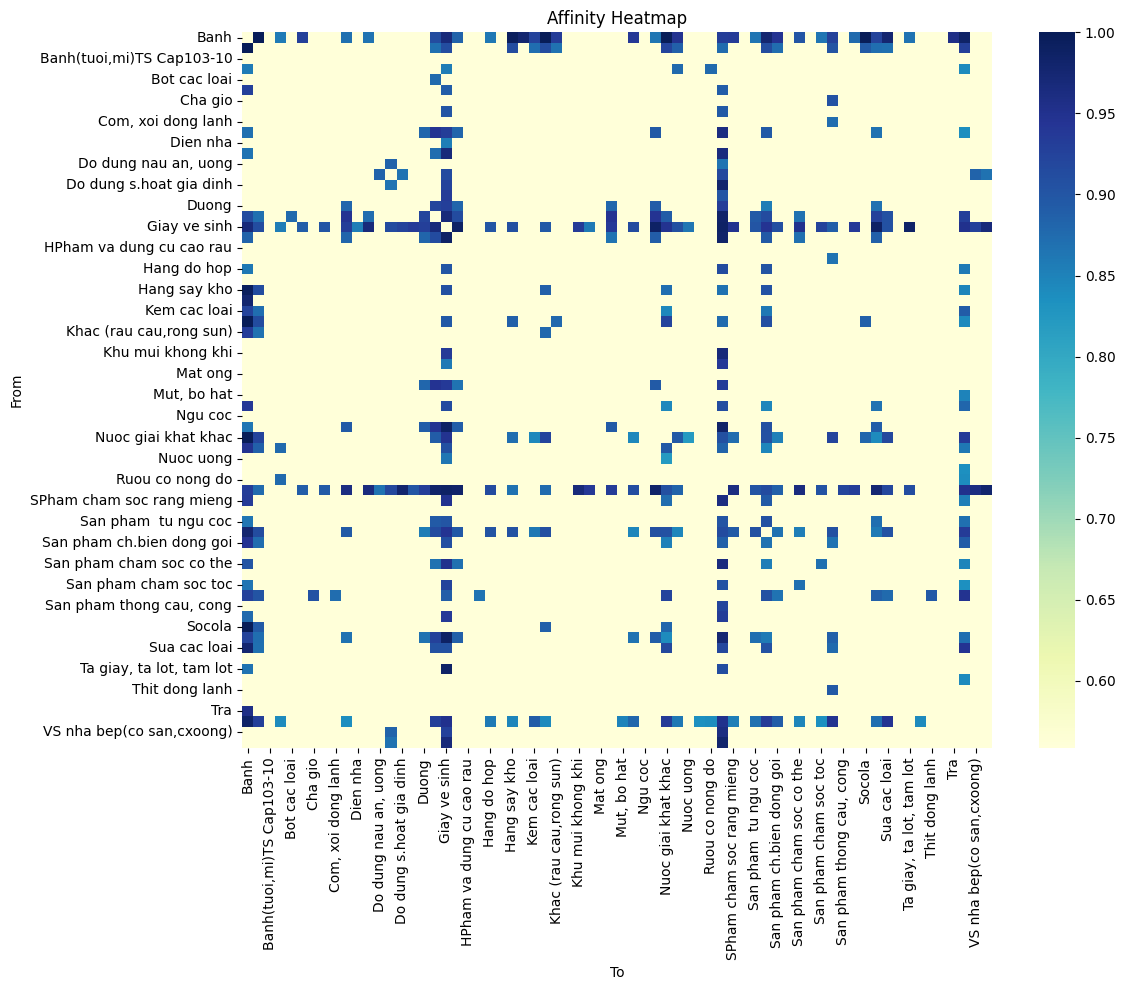

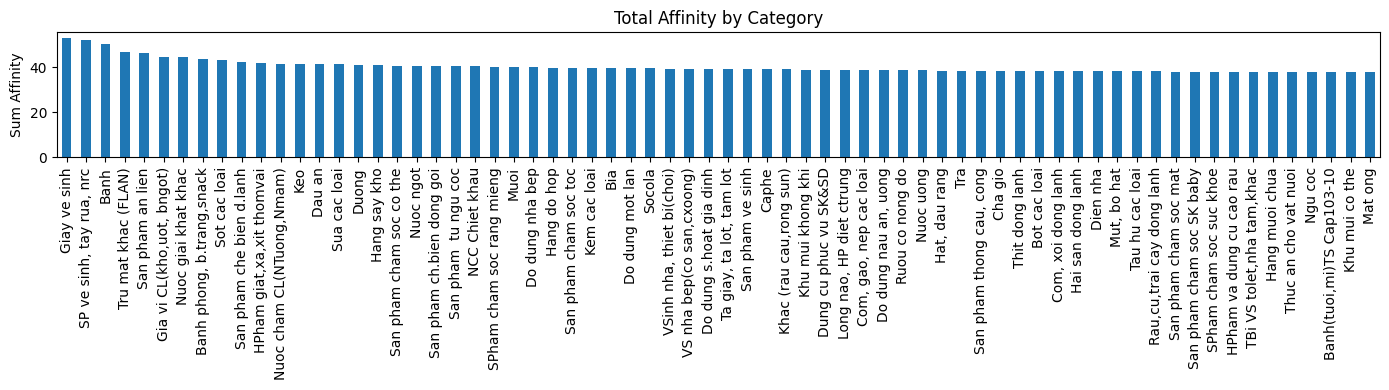

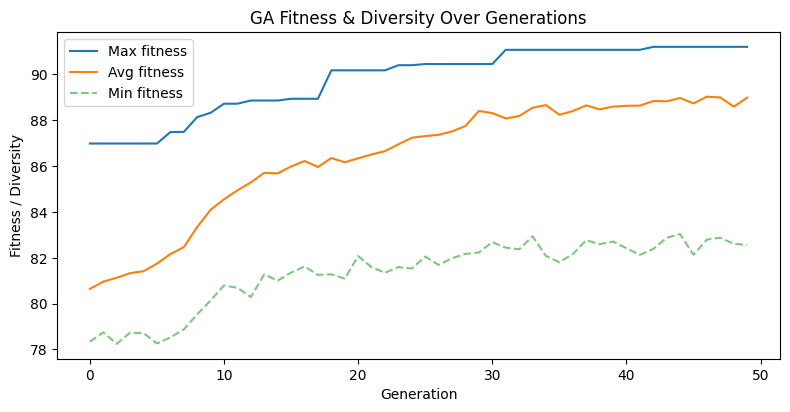

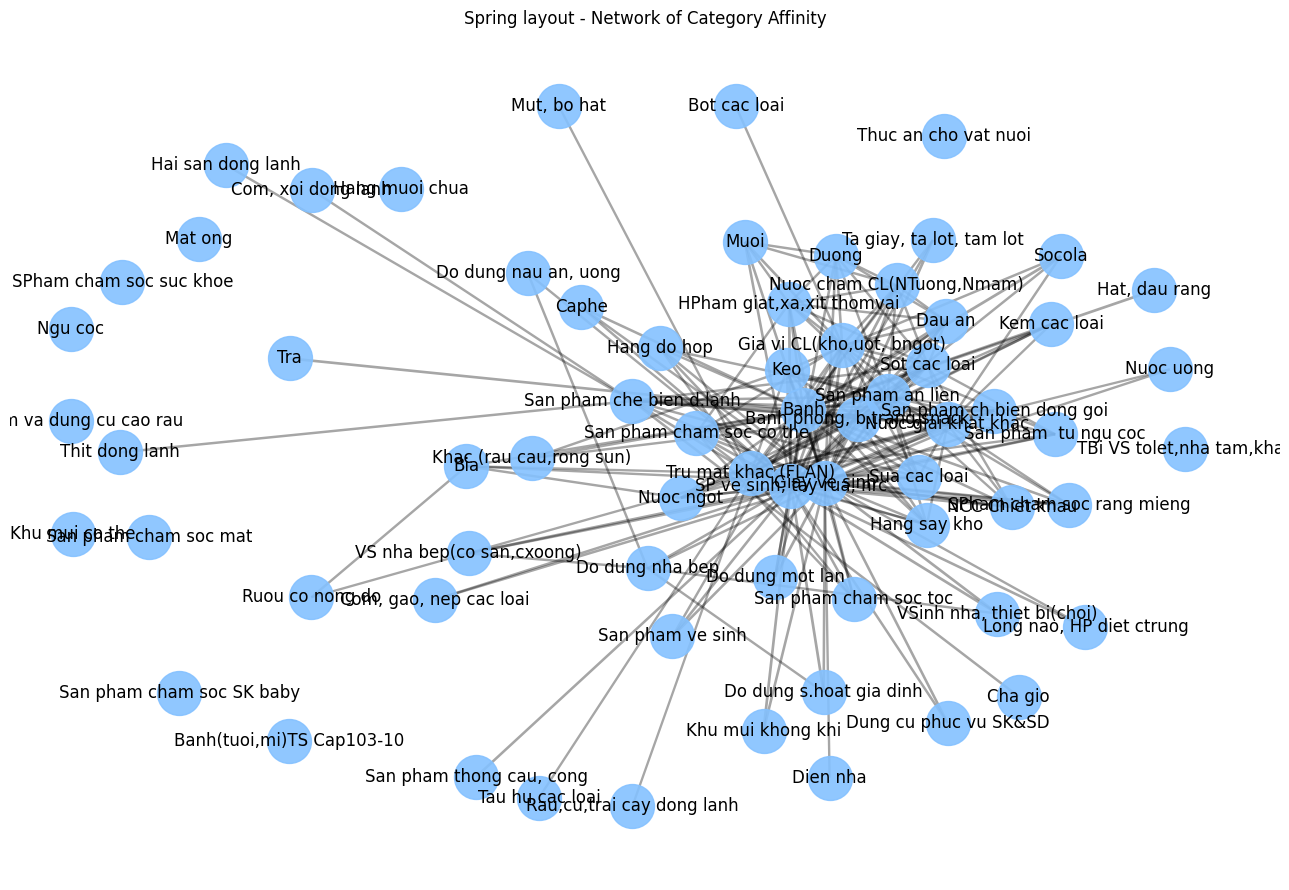

In [1]:
# src/pipelines/pipeline_layout_opt.py
import ast
import random
from typing import Dict, List, Optional, Tuple

from loguru import logger
import numpy as np
import optuna
import pandas as pd

from src.models.affinity import AffinityBuilder
from src.models.ga_optimizer import GAOptimizer
from src.models.greedy import GreedyLayout

from src.plots import LayoutVisualizer
from src.config import PROCESSED_DATA_DIR, INTERIM_DATA_DIR
from src.preprocess import DataLoader


# =============== Pipeline ===============
class LayoutOptimizationPipeline:
    def __init__(
        self,
        data: DataLoader,
        n_trials: int = 30,
        n_gen_final: int = 80,
        use_optuna: bool = True,
        selection: str = "tournament",
        crossover: str = "PMX",
        mutation: str = "shuffle",
        adaptive: bool = True,
        seed: int = 42,
    ):
        self.data = data
        self.n_trials = n_trials
        self.n_gen_final = n_gen_final
        self.use_optuna = use_optuna
        self.selection, self.crossover, self.mutation = selection, crossover, mutation
        self.adaptive = adaptive
        self.seed = seed
        np.random.seed(seed)
        random.seed(seed)

        self.all_items = data.all_items
        self.refrig_cats = data.refrig_cats

        self.affinity_builder = AffinityBuilder(
            self.data.assoc_rules,
            self.data.freq_itemsets,
            self.data.all_items,
            self.data.margin_matrix,
        )

        # holders
        self.ga_logbook: Optional[pd.DataFrame] = None
        self.best_logbook: Optional[pd.DataFrame] = None

        # cache nhẹ
        self._baseline_cached: Optional[List[str]] = None
        self._coords_cached: Optional[
            Tuple[List[Tuple[float, float]], Tuple[float, float]]
        ] = None
        self._cat_support_cached: Optional[Dict[str, float]] = None

    # ---- helpers ----
    def _coords_and_entrance(
        self, override_entr_xy: Optional[Tuple[float, float]] = None
    ):
        slots = self.data.sorted_slots_xy()
        coords = list(
            zip(slots["x"] + slots["width"] * 0.5, slots["y"] + slots["height"] * 0.5)
        )
        if override_entr_xy is not None:
            return coords, tuple(override_entr_xy)

        df = self.data.layout_real
        if ("is_entrance" in df.columns) and df["is_entrance"].fillna(0).astype(
            int
        ).any():
            row = (
                df.loc[df["is_entrance"].fillna(0).astype(int) == 1]
                .sort_values(["y", "x"])
                .iloc[0]
            )
            ex = float(row["x"]) + float(row.get("width", 0)) * 0.5
            ey = float(row["y"]) + float(row.get("height", 0)) * 0.5
            return coords, (ex, ey)

        row = df.sort_values(["y", "x"]).iloc[0]
        ex = float(row["x"]) + float(row.get("width", 0)) * 0.5
        ey = float(row["y"]) + float(row.get("height", 0)) * 0.5
        return coords, (ex, ey)

    def _cat_support(self) -> Dict[str, float]:
        if self._cat_support_cached is not None:
            return self._cat_support_cached
        cs = {c: 0.0 for c in self.all_items}
        df = self.data.freq_itemsets
        if "items" in df.columns and "support" in df.columns:
            for _, r in df.iterrows():
                try:
                    items = ast.literal_eval(r["items"])
                except Exception:
                    continue
                sup = float(r["support"])
                for it in items:
                    if it in cs:
                        cs[it] = max(cs[it], sup)
        self._cat_support_cached = cs
        return cs

    def _seed_layout_real(self) -> List[str]:
        if self._baseline_cached is not None:
            return self._baseline_cached
        known = set(self.all_items)
        baseline = (
            self.data.sorted_slots_xy()["Category"]
            .astype(str)
            .apply(lambda x: x if x in known else None)
            .dropna()
            .tolist()
        )
        self._baseline_cached = baseline
        return baseline

    def _filter_to_slot_len(self, layout: List[str]) -> List[str]:
        # dùng số slot thực có trong sorted_slots_xy
        slots = self.data.sorted_slots_xy()
        return layout[: len(slots)]

    # ---- Optuna objective ----
    def _objective(self, trial: optuna.trial.Trial) -> float:
        # Affinity params
        lift_threshold = trial.suggest_float("lift_threshold", 0.0, 2.0)
        w_lift = trial.suggest_float("w_lift", 0.1, 1.0)
        w_conf = trial.suggest_float("w_conf", 0.0, 1.0)
        w_margin = trial.suggest_float("w_margin", 0.0, 1.0)
        gamma = trial.suggest_float("gamma", 0.5, 4.0)

        # Mixed fitness (gọn)
        w_aff = trial.suggest_float("w_aff", 0.5, 2.0)
        w_entr = trial.suggest_float("w_entr", 0.0, 2.0)
        gamma_support = trial.suggest_float(
            "gamma_support", 0.0, 1.5
        )  # cho phép 0.0 để tắt

        # normalize weights
        s = w_lift + w_conf + w_margin
        w_lift, w_conf, w_margin = w_lift / s, w_conf / s, w_margin / s

        # Build affinity
        affinity = self.affinity_builder.build_affinity(
            lift_threshold=lift_threshold,
            w_lift=w_lift,
            w_conf=w_conf,
            w_margin=w_margin,
        )
        affinity = self.affinity_builder.normalize(affinity)
        affinity = self.affinity_builder.kernelize(affinity, gamma=gamma)

        # Seeds & inputs (lazy)
        baseline = self._seed_layout_real()

        layout_greedy = None
        if not baseline:
            greedy = GreedyLayout(self.all_items)
            layout_greedy = greedy.local_search(greedy.init_layout(affinity), affinity)

        coords = entr_xy = None
        cat_support = None
        if w_entr > 0:
            if self._coords_cached is None:
                self._coords_cached = self._coords_and_entrance()
            coords, entr_xy = self._coords_cached
            if gamma_support > 0:
                cat_support = self._cat_support()

        seed_layout = baseline or layout_greedy

        # One-optimizer (decoder tự chọn theo refrig_cats)
        ga = GAOptimizer(
            all_items=self.all_items,
            affinity_matrix=affinity,
            refrig_cats=self.refrig_cats,  # [] => global; có list => two-zone
            hard_rules={},  # truyền nếu có luật cứng
            coords=coords,
            entr_xy=entr_xy,
            cat_support=cat_support,
            w_aff=w_aff,
            w_entr=w_entr,
            gamma_support=gamma_support,
            selection=self.selection,
            crossover=self.crossover,
            mutation=self.mutation,
            anchor_start=None,
        )

        # GA params: cố định để search space gọn
        best_layout, best_fitness, _ = ga.run(
            ngen=30,
            pop_size=200,
            seed=self.seed,
            elite_ratio=0.06,
            adaptive=self.adaptive,
            baseline=seed_layout,
            log_csv_path=None,
            as_dataframe=True,
        )

        # chỉ lưu best_layout vào trial
        trial.set_user_attr("best_layout", self._filter_to_slot_len(best_layout))
        return float(best_fitness)

    # ---- Public API ----
    def tune(self):
        if not self.use_optuna:
            # chạy nhanh không tune: giữ tham số mặc định hợp lý
            self.best_params = {
                "lift_threshold": 0.5,
                "w_lift": 0.6,
                "w_conf": 0.4,
                "w_margin": 0.0,
                "gamma": 1.0,
                "w_aff": 1.0,
                "w_entr": 0.0,
                "gamma_support": 0.0,
            }
            self.best_layout = self._filter_to_slot_len(self._seed_layout_real())
            self.study = None
            self.best_logbook = None
            logger.info("Tune skipped. Using default params.")
            return None

        sampler = optuna.samplers.TPESampler(seed=self.seed)
        study = optuna.create_study(direction="maximize", sampler=sampler)
        study.optimize(self._objective, n_trials=self.n_trials)
        self.study = study
        self.best_params = study.best_params
        self.best_layout = study.best_trial.user_attrs["best_layout"]

        # Không kéo logbook từ trial nữa
        self.best_logbook = None

        logger.info("Best params:", self.best_params)
        logger.info("Best layout (from Optuna):", self.best_layout)
        return study

    def run_final(self):
        if not hasattr(self, "best_params"):
            raise RuntimeError("Hãy gọi tune() trước.")

        p = self.best_params
        affinity = self.affinity_builder.build_affinity(
            lift_threshold=p["lift_threshold"],
            w_lift=p["w_lift"],
            w_conf=p["w_conf"],
            w_margin=p["w_margin"],
        )
        affinity = self.affinity_builder.normalize(affinity)
        affinity = self.affinity_builder.kernelize(affinity, gamma=p["gamma"])

        # lazy theo w_entr/gamma_support
        coords = entr_xy = None
        cat_support = None
        if p["w_entr"] > 0:
            if self._coords_cached is None:
                self._coords_cached = self._coords_and_entrance()
            coords, entr_xy = self._coords_cached
            if p["gamma_support"] > 0:
                cat_support = self._cat_support()

        baseline = self._seed_layout_real()

        # One-optimizer
        ga = GAOptimizer(
            all_items=self.all_items,
            affinity_matrix=affinity,
            refrig_cats=self.refrig_cats,
            hard_rules={},
            coords=coords,
            entr_xy=entr_xy,
            cat_support=cat_support,
            w_aff=p["w_aff"],
            w_entr=p["w_entr"],
            gamma_support=p["gamma_support"],
            selection=self.selection,
            crossover=self.crossover,
            mutation=self.mutation,
        )

        # lưu logbook final ra CSV
        log_csv = PROCESSED_DATA_DIR / "ga_logbook_final.csv"

        best_layout, best_fitness, logbook = ga.run(
            ngen=self.n_gen_final,
            pop_size=200,  # cố định để repeatable
            seed=self.seed,
            elite_ratio=0.06,  # cố định
            adaptive=self.adaptive,
            baseline=baseline,
            log_csv_path=str(log_csv),
            as_dataframe=True,
        )

        # lưu logbook để vẽ
        self.ga_logbook = getattr(ga, "logbook_df", None)
        if self.ga_logbook is None:
            try:
                self.ga_logbook = pd.DataFrame(logbook)
            except Exception:
                self.ga_logbook = None

        # Xuất file theo slot (y,x)
        best_layout = [str(c) for c in self._filter_to_slot_len(best_layout)]
        slots = self.data.sorted_slots_xy()
        n = min(len(best_layout), len(slots))
        layout_opt = pd.DataFrame(
            {
                "Category": best_layout[:n],
                "x": slots.loc[: n - 1, "x"].to_list(),
                "y": slots.loc[: n - 1, "y"].to_list(),
                "width": slots.loc[: n - 1, "width"].to_list(),
                "height": slots.loc[: n - 1, "height"].to_list(),
            }
        )
        layout_opt["cx"] = layout_opt["x"] + layout_opt["width"] / 2.0
        layout_opt["cy"] = layout_opt["y"] + layout_opt["height"] / 2.0

        self.affinity = affinity
        self.layout_opt = layout_opt
        self.best_fitness = best_fitness

        logger.info("\nBest layout:", best_layout)
        logger.info(f"Best fitness: {best_fitness:.4f}")
        return layout_opt, best_fitness

    def plot_all(self):
        if not hasattr(self, "layout_opt"):
            logger.info("Hãy chạy run_final() trước khi plot.")
            return
        LayoutVisualizer.plot_affinity_heatmap(self.affinity)
        LayoutVisualizer.plot_affinity_bar(self.affinity)
        # Ưu tiên logbook final; nếu không có thì dùng best_logbook từ tune()
        log_df = self.ga_logbook if self.ga_logbook is not None else self.best_logbook
        if log_df is not None and not log_df.empty:
            LayoutVisualizer.plot_ga_convergence(log_df)
        LayoutVisualizer.plot_spring_layout(self.affinity, threshold=0.8)


# =============== Example usage ===============
if __name__ == "__main__":
    df = DataLoader(
        assoc_rules_path=PROCESSED_DATA_DIR / "association_rules.csv",
        freq_itemsets_path=PROCESSED_DATA_DIR / "frequent_itemsets.csv",
        layout_real_path=INTERIM_DATA_DIR / "layout.csv",
        margin_matrix_path=None,
    )

    pipeline = LayoutOptimizationPipeline(
        data=df,
        n_trials=20,
        n_gen_final=50,
        selection="tournament",
        crossover="PMX",
        mutation="shuffle",
        adaptive=True,
        seed=42,
    )

    pipeline.tune()
    pipeline.run_final()
    pipeline.plot_all()

In [23]:
# src/plots_ga.py — CLASS VERSION (refactor giữ nguyên API)
from pathlib import Path
from typing import Dict, Optional, Tuple, List
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


class GAPlotter:

    # ---------- public API ----------
    def visualize_layout(
        self,
        df_layout: pd.DataFrame,
        out_png: Path,
        cell_size: Optional[float] = None,
        title: str = "Layout (GA) — preview",
        label_fontsize: int = 4,
        show_labels: bool = True,
    ) -> None:
        """
        Vẽ 1 layout.
        Giữ nguyên chữ ký hàm & mặc định như phiên bản cũ.
        """
        self._validate_df(df_layout)
        cs = (
            float(cell_size)
            if cell_size is not None
            else self._estimate_cell_size(df_layout)
        )
        grid, id2name = self._rasterize_grid(df_layout, cs)
        self._draw_grid(
            grid,
            id2name,
            title=title,
            out_png=out_png,
            label_fontsize=(label_fontsize if show_labels else 0),
        )

    def compare_layouts(
        self,
        df_before: pd.DataFrame,
        df_after: pd.DataFrame,
        out_png: Path,
        titles: Tuple[str, str] = ("Trước", "Sau"),
        cell_size_before: Optional[float] = None,
        cell_size_after: Optional[float] = None,
        label_mode: str = "both",  # "left" | "right" | "both" | "none"
        label_fontsize: int = 4,
    ) -> None:
        """
        Vẽ 2 layout cạnh nhau, dùng chung bảng màu để so trực quan.
        Giữ nguyên chữ ký hàm & mặc định như phiên bản cũ.
        """
        self._validate_df(df_before)
        self._validate_df(df_after)

        shared_map = self._build_shared_mapping(df_before, df_after)

        # Cell size: nếu không chỉ định, ước lượng riêng; có thể buộc chung nếu muốn.
        cs_a = (
            float(cell_size_before)
            if cell_size_before is not None
            else self._estimate_cell_size(df_before)
        )
        cs_b = (
            float(cell_size_after)
            if cell_size_after is not None
            else self._estimate_cell_size(df_after)
        )

        grid_a, id2name = self._rasterize_grid(df_before, cs_a, name2id=shared_map)
        grid_b, _ = self._rasterize_grid(df_after, cs_b, name2id=shared_map)

        H1, W1 = int(grid_a.shape[0]), int(grid_a.shape[1])
        H2, W2 = int(grid_b.shape[0]), int(grid_b.shape[1])
        max_id = max(
            int(grid_a.max()) if grid_a.size else 0,
            int(grid_b.max()) if grid_b.size else 0,
        )

        cmap, norm = self._make_cmap_norm(max_id)

        # Kích thước figure gọn, cân theo tổng chiều rộng
        fig_w, fig_h = self._figure_size(W1 + W2, max(H1, H2), cols=2)
        fig, axs = plt.subplots(1, 2, figsize=(fig_w, fig_h))

        axs[0].imshow(grid_a, cmap=cmap, norm=norm, interpolation="none")
        axs[0].set_title(titles[0], fontsize=6)
        self._axes_off(axs[0])

        axs[1].imshow(grid_b, cmap=cmap, norm=norm, interpolation="none")
        axs[1].set_title(titles[1], fontsize=6)
        self._axes_off(axs[1])

        if label_mode in ("left", "both"):
            self._draw_labels(axs[0], grid_a, id2name, fontsize=label_fontsize)
        if label_mode in ("right", "both"):
            self._draw_labels(axs[1], grid_b, id2name, fontsize=label_fontsize)

        plt.savefig(out_png, dpi=220, bbox_inches="tight")
        plt.close(fig)

    # ---------- internals ----------
    @staticmethod
    def _validate_df(df: pd.DataFrame) -> None:
        need_cols = {"Category", "x", "y", "width", "height"}
        missing = need_cols - set(df.columns)
        if missing:
            raise ValueError(f"Thiếu cột bắt buộc trong layout: {sorted(missing)}")
        if df.empty:
            raise ValueError("DataFrame layout rỗng.")

    def _estimate_cell_size(self, df: pd.DataFrame) -> float:
        min_dim = np.minimum(
            df["width"].to_numpy(dtype=float), df["height"].to_numpy(dtype=float)
        )
        pos = min_dim[min_dim > 0]
        if pos.size == 0:
            return 5.0
        # median/4 như cũ, nhưng clamp >=1
        return float(max(1.0, int(np.median(pos) / 4)))

    def _build_shared_mapping(
        self, df_a: pd.DataFrame, df_b: Optional[pd.DataFrame] = None
    ) -> Dict[str, int]:
        cats_a = pd.Index(df_a["Category"].astype(str).unique())
        cats = (
            cats_a.union(pd.Index(df_b["Category"].astype(str).unique()))
            if df_b is not None
            else cats_a
        )
        return {c: i + 1 for i, c in enumerate(cats)}

    def _rasterize_grid(
        self,
        df: pd.DataFrame,
        cell_size: float,
        name2id: Optional[Dict[str, int]] = None,
    ) -> Tuple[np.ndarray, Dict[int, str]]:
        if cell_size <= 0:
            raise ValueError("cell_size phải > 0.")

        if name2id is None:
            name2id = self._build_shared_mapping(df)
        id2name = {v: k for k, v in name2id.items()}

        # Biên bao quanh + padding
        x0, y0 = float(df["x"].min()), float(df["y"].min())
        x1 = float((df["x"] + df["width"]).max())
        y1 = float((df["y"] + df["height"]).max())
        pad_x = (x1 - x0) * 0.06
        pad_y = (y1 - y0) * 0.06
        min_x, min_y = x0 - pad_x, y0 - pad_y
        max_x, max_y = x1 + pad_x, y1 + pad_y

        # Kích thước lưới
        W = int(math.ceil((max_x - min_x) / cell_size))
        H = int(math.ceil((max_y - min_y) / cell_size))

        # RAM guard ~10M ô
        if W * H > 10_000_000:
            scale = math.sqrt((W * H) / 10_000_000.0)
            cell_size *= scale
            W = int(math.ceil((max_x - min_x) / cell_size))
            H = int(math.ceil((max_y - min_y) / cell_size))

        grid = np.zeros((H, W), dtype=np.int32)

        # Vẽ từng ô danh mục lên grid
        for _, r in df.iterrows():
            did = name2id[str(r["Category"])]
            rx, ry = float(r["x"]), float(r["y"])
            rw, rh = float(r["width"]), float(r["height"])
            if rw <= 0 or rh <= 0:
                continue
            gx0 = int((rx - min_x) // cell_size)
            gy0 = int((ry - min_y) // cell_size)
            gx1 = int(math.ceil((rx + rw - min_x) / cell_size))
            gy1 = int(math.ceil((ry + rh - min_y) / cell_size))

            # Clamp trong lưới
            gx0 = max(0, min(gx0, W))
            gx1 = max(0, min(gx1, W))
            gy0 = max(0, min(gy0, H))
            gy1 = max(0, min(gy1, H))
            if gx0 >= gx1 or gy0 >= gy1:
                continue
            grid[gy0:gy1, gx0:gx1] = did

        return grid, id2name

    def _draw_grid(
        self,
        grid: np.ndarray,
        id2name: Dict[int, str],
        title: str,
        out_png: Path,
        label_fontsize: int,
    ) -> None:
        H, W = grid.shape
        max_id = int(grid.max()) if grid.size else 0
        cmap, norm = self._make_cmap_norm(max_id)

        fig_w, fig_h = self._figure_size(W, H, cols=1)
        fig, ax = plt.subplots(figsize=(fig_w, fig_h))
        ax.imshow(grid, cmap=cmap, norm=norm, interpolation="none")

        if label_fontsize > 0:
            self._draw_labels(ax, grid, id2name, fontsize=label_fontsize)

        ax.set_title(title, fontsize=6)
        self._axes_off(ax)
        plt.savefig(out_png, dpi=220, bbox_inches="tight")
        plt.close(fig)

    def _make_cmap_norm(self, max_id: int):
        # Màu 0 là nền sáng; các ID >=1 dùng palette
        base = plt.cm.get_cmap("tab20", max(1, max_id))
        colors = ["#F9F9F9"] + [base(i) for i in range(max_id)]
        cmap = mcolors.ListedColormap(colors)
        bounds = list(range(0, max_id + 2))
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        return cmap, norm

    @staticmethod
    def _draw_labels(ax, grid: np.ndarray, id2name: Dict[int, str], fontsize: int = 4):
        # Vẽ nhãn tại tâm trọng số pixel của mỗi ID
        ids = np.unique(grid)
        ids = ids[ids > 0]
        for did in ids:
            ys, xs = np.where(grid == did)
            if xs.size == 0:
                continue
            cx, cy = xs.mean(), ys.mean()
            name = id2name.get(int(did), f"ID {int(did)}")
            ax.text(cx, cy, name, va="center", ha="center", fontsize=fontsize)

    @staticmethod
    def _axes_off(ax):
        ax.grid(False)
        ax.tick_params(
            axis="both",
            which="both",
            bottom=False,
            left=False,
            labelbottom=False,
            labelleft=False,
        )

    @staticmethod
    def _figure_size(W: int, H: int, cols: int = 1) -> Tuple[float, float]:
        # Giữ tỉ lệ như bản cũ: base 18 theo H, clamp tối đa 30
        base_w = 18.0 * (float(W) / max(1.0, float(H)))
        fig_w = min(30.0, base_w if cols == 1 else base_w)  # đã cộng W của cả 2 khi gọi
        fig_h = min(30.0, 18.0)
        return float(fig_w), float(fig_h)


# ======== Demo / cách chạy mẫu (không tự chạy khi import) ========
if __name__ == "__main__":
    try:
        from src.config import OUTPUT_DATA_DIR

        # `pipeline` phải tồn tại trong scope chạy script này (ví dụ bạn import và gán global trước đó).
        if "pipeline" not in globals():
            raise NameError("Chưa có biến `pipeline` trong scope hiện tại.")
        plotter = GAPlotter()

        df_before = pipeline.data.layout_real.copy()
        df_after = pipeline.layout_opt.copy()

        plotter.visualize_layout(
            df_after, OUTPUT_DATA_DIR / "ga_preview.png", show_labels=True
        )

        plotter.compare_layouts(
            df_before,
            df_after,
            OUTPUT_DATA_DIR / "ga_compare.png",
            titles=("Trước", "Sau"),
            label_mode="both",
            label_fontsize=5,
        )
        print("Đã xuất hình vào:", OUTPUT_DATA_DIR)
    except Exception as e:
        print(
            "[plots_ga demo] Để chạy demo, hãy đảm bảo bạn đã có biến `pipeline` (đã run_final) trong scope.\n"
            f"Lỗi: {e}"
        )

C:\Users\vinh-nt\AppData\Local\Temp\ipykernel_3572\1797448117.py:221: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap("tab20", max(1, max_id))
C:\Users\vinh-nt\AppData\Local\Temp\ipykernel_3572\1797448117.py:221: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap("tab20", max(1, max_id))


Đã xuất hình vào: D:\DataLocal\vinh-nt\My Documents\GitHub\Retail-Layout-Optimization-with-ML-Metaheuristics\data\output
